In [15]:
"""pip install scikit-optimize
pip install optuna
pip install fitterpip install hyperopt
pip install lightgbm 
"""

'pip install scikit-optimize\npip install optuna\npip install fitterpip install hyperopt\npip install lightgbm \n'

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sn
import multiprocessing

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn import metrics
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score, classification_report, roc_curve


# <span style="color:darkred"> Objetivo </span>

<span style="color:darkblue"> Comparar las técnicas de optimización mediante validación cruzada RandomizedSearchCV con GridSearchCV, posteriormente encontrar modelos que puedan predecir rechazado de canales con los mejores hiperparámetros mejorando las métricas: Accuracy, Sensibilidad, precisión, AUC y especificidad.</span>

In [17]:
data=pd.read_excel(r"D:\Never Urueta\2023\Tesis\Data.xlsx") 

In [18]:
data1 = data.drop(["PBA", "CF", "CAPACIDAD DEL CUARTO FRIO  ", "Indicador", "VT1", "VT2", "DESTINO"], axis=1)

In [19]:
data1.isnull().sum() #Datos faltantes
data1['Tamin'].fillna(data1['Tamin'].median(), inplace=True)
print("valores perdidos en Tamin: " + 
      str(data1['Tamin'].isnull().sum()))
data1['Taamax'].fillna(data1['Taamax'].median(), inplace=True)
print("valores perdidos en Taamax: " + 
      str(data1['Taamax'].isnull().sum()))

valores perdidos en Tamin: 0
valores perdidos en Taamax: 0


# <span style="color:darkred"> Variable de Respuesta </span>

In [20]:
data1.loc[data1["Rechazados"] > 0, "Rechazados"] = 1
print(data1.Rechazados.value_counts().sort_index())

0    1329
1     585
Name: Rechazados, dtype: int64


# <span style="color:darkred"> Correlación variables numéricas </span>

<span style="color:darkblue"> De archivo ejecutado con regresión se evidenció una correlación entre dos variables independientes, por lo que procederemos a eliminar a una, la variable Ocupación.

In [21]:
data1 = data1.drop(["Ocupacion"],axis=1)

# <span style="color:darkred"> Variabes cualitativas </span>

<span style="color:darkblue">Eliminamos los registros de PBA2 solo quedandonos con PBA1 

In [22]:
data1 = data1.loc[data1["TIPO_CAP_CF"] != "PBA2", :]

In [23]:
# Reparto de datos en train y test
# ==============================================================================
X_train, X_test, y_train, y_test = train_test_split(
                                        data1.drop('Rechazados', axis = 'columns'),
                                        data1['Rechazados'],
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

# <span style="color:darkred"> Preprocesado y Modelado 

</span>

> <span style="color:darkblue"> Se estandarizan las variables numericas y se dummyfican las categóricas y luego se procesan en conjunto con los algoritmos, que en este caso son: </span>
>>  - <span style="color:darkblue"> K Nearest Neighbor - knn
>>  - <span style="color:darkblue"> Random Forest - rf
>>  - <span style="color:darkblue"> Maquinas de Vectores de Soporte - SVM
>>  - <span style="color:darkblue"> Light MGB  - lgbm


In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as lgb

# Pipeline: preprocesado + modelo
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

#Zona de modelos
knn = Pipeline([('preprocessing', preprocessor),
                 ('modelo', KNeighborsClassifier())])
rf = Pipeline([('preprocessing', preprocessor),
                     ('modelo', RandomForestClassifier(n_estimators = 10))])
svc_m = Pipeline([('preprocessing', preprocessor),
                ('modelo', SVC(gamma="auto"))])
lgg = Pipeline([('preprocessing', preprocessor),
                ('modelo', lgb.LGBMClassifier())])

# Zona de parametros 
pd_knn = {
    'modelo__n_neighbors': range(1, 50, 2),
    'modelo__weights': ['uniform', 'distance'],
    'modelo__metric'   : ['euclidean', 'manhattan', 'minkowski'],
}
pd_rf = {
    'modelo__n_estimators': [10, 100, 1000,10000],
    'modelo__max_features': ['auto', 'sqrt', 'log2'],
    'modelo__max_depth'   : [None, 3, 5, 10, 30, 100, 500]
}

pd_svc_m = {
    'modelo__C': [50, 10, 1.0, 0.1, 0.01],
    'modelo__kernel': ['poly', 'rbf', 'sigmoid'],
    'modelo__gamma' : ['scale', 'auto'],
}
pd_lgg = {
    'modelo__class_weight': [None,'balanced'],
    'modelo__boosting_type': ['gbdt', 'goss', 'dart'],
    'modelo__num_leaves' : [30,50,100,150],
    'modelo__learning_rate' : list(np.logspace(np.log(0.005), np.log(0.2), base = np.exp(1), num = 10)),
}

In [25]:
"""def my_refit_criteria(cv_results_):
    return np.argmax(
        (0.8*cv_results_['mean_test_accuracy'])
        + (0.3*cv_results_['mean_test_recall'])
    )"""

"def my_refit_criteria(cv_results_):\n    return np.argmax(\n        (0.8*cv_results_['mean_test_accuracy'])\n        + (0.3*cv_results_['mean_test_recall'])\n    )"

# <span style="color:darkred"> Optimización de Hiperparámetros y Ejecución de Algoritmos 
<span style="color:darkblue"> 

Se aplicarán a los argoritmos mencionados las técnicas de optimización  GridSearchCV y RandomSearchCV.

GridSearchCV prueba todas las combinaciones posibles de parámetros que se desean probar en el modelo. Cada uno de esos parámetros se prueba en una serie de iteraciones de validación cruzada (Cross Validation), mientras que RandomSearchCV muestrea al azar a partir de una variedad de parámetros con la idea de cubrir el conjunto de parámetros casi óptimo más rápido que utilizando el GridSearch.

Ambos métodos se utilizaran teniendo como referencia de optimización la métrica de Especificidad 

# <span style="color:darkred"> K-Nearest Neighbor (kNN)

## <span style="color:darkgreen">  Evaluación Inicial y Búsqueda gridSearchCV </span>

In [26]:
#Evaluación Inicial de los modelos
models = [knn, rf, svc_m,lgg]

cols = ['Técnica','knn', 'rforest',  'SVM', 'lgbm']
resul = pd.DataFrame(columns=cols)
resul.set_index("Técnica",inplace=True)
resul.loc['Standard'] = [0,0,0,0]
resul.loc['GridSearch'] = [0,0,0,0]
resul.loc['RandomSearch'] = [0,0,0,0]
col=0
for model in models:
    model.fit(X_train,y_train.values.ravel())
    resul.iloc[0,col] = model.score(X_test,y_test)
    col += 1
resul.head()
# Resto
n_iter_    = 20
scoring_   = "recall"# ['accuracy', 'f1', 'precision', 'recall']
n_jobs_    = multiprocessing.cpu_count() - 1
cv_        = RepeatedKFold(n_splits = 5, n_repeats = 3) 

Grid_Tecn = GridSearchCV(
    estimator=knn, param_grid=pd_knn, n_jobs=n_jobs_, 
    cv=cv_ ,scoring= scoring_, refit=True, error_score=0
)
_=Grid_Tecn.fit(X = X_train, y = y_train)

param0 = Grid_Tecn.best_params_
mejor= Grid_Tecn.best_estimator_
predicciones = mejor.predict(X = X_test)
resul.iloc[1,0] = accuracy_score(y_true  = y_test, y_pred  = predicciones)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


## <span style="color:darkgreen"> Búsqueda RandomSearchCV </span>

In [27]:
Random_Tecn= RandomizedSearchCV(
    estimator=knn, param_distributions=pd_knn, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit=True, verbose= 0,random_state = 1234,return_train_score = True
    )
_=Random_Tecn.fit(X = X_train, y = y_train)

param1 = Random_Tecn.best_params_
mejor1= Random_Tecn.best_estimator_
predicciones1 = mejor1.predict(X = X_test)
resul.iloc[2,0] = accuracy_score(y_true  = y_test, y_pred  = predicciones1)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


# <span style="color:darkred">  Random Forest </span>

## <span style="color:darkgreen">  Búsqueda GridSearchCV </span>

In [28]:
Grid_Tecn = GridSearchCV(
    estimator=rf, param_grid=pd_rf, n_jobs=n_jobs_, 
    cv=cv_ ,scoring=scoring_, refit=True, error_score=0
)
_=Grid_Tecn.fit(X = X_train, y = y_train)

param2 = Grid_Tecn.best_params_
mejor2= Grid_Tecn.best_estimator_
predicciones2 = mejor2.predict(X = X_test)
resul.iloc[1,1] = accuracy_score(y_true  = y_test, y_pred  = predicciones2)

## <span style="color:darkgreen">  Búsqueda RandomSearchCV </span>

In [29]:
Random_Tecn= RandomizedSearchCV(
    estimator=rf, param_distributions=pd_rf, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit=True, verbose= 0,random_state = 123,return_train_score = True
    )
_=Random_Tecn.fit(X = X_train, y = y_train)

param3 = Random_Tecn.best_params_
mejor3= Random_Tecn.best_estimator_
predicciones3 = mejor3.predict(X = X_test)
resul.iloc[2,1] = accuracy_score(y_true  = y_test, y_pred  = predicciones3)


# <span style="color:darkred"> Máquinas Vectores de Soporte </span>

## <span style="color:darkgreen">  Búsqueda GridSearchCV </span>

In [30]:
Grid_Tecn = GridSearchCV(
    estimator=svc_m, param_grid=pd_svc_m, n_jobs=n_jobs_, 
    cv=cv_ ,scoring=scoring_, refit=True, error_score=0
)
_=Grid_Tecn.fit(X = X_train, y = y_train)

param4 = Grid_Tecn.best_params_
mejor4= Grid_Tecn.best_estimator_
predicciones4 = mejor4.predict(X = X_test)
resul.iloc[1,2] = accuracy_score(y_true  = y_test, y_pred  = predicciones4)

## <span style="color:darkgreen">  Búsqueda RandomSearchCV </span>

In [31]:
Random_Tecn= RandomizedSearchCV(
    estimator=svc_m, param_distributions=pd_svc_m, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit=True, verbose= 0,random_state = 123,return_train_score = True
    )
Random_Tecn.fit(X = X_train, y = y_train)

param5 = Random_Tecn.best_params_
mejor5 = Random_Tecn.best_estimator_
predicciones5 = mejor5.predict(X = X_test)
resul.iloc[2,2] = accuracy_score(y_true  = y_test, y_pred  = predicciones5)

# <span style="color:darkred"> LGBM </span>

## <span style="color:darkgreen"> Búsqueda GridSearchCV </span>

In [32]:
Grid_Tecn = GridSearchCV(
    estimator=lgg, param_grid=pd_lgg, n_jobs=n_jobs_, 
    cv=cv_ ,scoring=scoring_, refit=True, error_score=0
)
_=Grid_Tecn.fit(X = X_train, y = y_train)

param6 = Grid_Tecn.best_params_
mejor6 = Grid_Tecn.best_estimator_
predicciones6 = mejor6.predict(X = X_test)
resul.iloc[1,3] = accuracy_score(y_true  = y_test, y_pred  = predicciones6)


## <span style="color:darkgreen"> Búsqueda RandomSearchCV </span>

In [33]:
Random_Tecn= RandomizedSearchCV(
    estimator=lgg, param_distributions=pd_lgg, n_iter=n_iter_,
    scoring=scoring_, n_jobs=n_jobs_, cv=cv_, refit=True, verbose= 0,random_state = 123,return_train_score = True
    )
_=Random_Tecn.fit(X = X_train, y = y_train)

param7 = Random_Tecn.best_params_
mejor7= Random_Tecn.best_estimator_
predicciones7= mejor7.predict(X = X_test)
resul.iloc[2,3] = accuracy_score(y_true  = y_test, y_pred  = predicciones7)

# <span style="color:darkred"> Tablas de Métricas por Algoritmo y método de optimización </span>

In [34]:
resul2 = resul.iloc[1:3,:].copy()  
resul2.iloc[0,0] = recall_score(y_test,predicciones)
resul2.iloc[1,0] = recall_score(y_test,predicciones1)
resul2.iloc[0,1] = recall_score(y_test,predicciones2)
resul2.iloc[1,1] = recall_score(y_test,predicciones3)
resul2.iloc[0,2] = recall_score(y_test,predicciones4)
resul2.iloc[1,2] = recall_score(y_test,predicciones5)
resul2.iloc[0,3] = recall_score(y_test,predicciones6)
resul2.iloc[1,3] = recall_score(y_test,predicciones7)

resul3 = resul2.copy()
resul3.iloc[0,0] = recall_score(y_test,predicciones, average=None)[0]
resul3.iloc[1,0] = recall_score(y_test,predicciones1, average=None)[0]
resul3.iloc[0,1] = recall_score(y_test,predicciones2, average=None)[0]
resul3.iloc[1,1] = recall_score(y_test,predicciones3, average=None)[0]
resul3.iloc[0,2] = recall_score(y_test,predicciones4, average=None)[0]
resul3.iloc[1,2] = recall_score(y_test,predicciones5, average=None)[0]
resul3.iloc[0,3] = recall_score(y_test,predicciones6, average=None)[0]
resul3.iloc[1,3] = recall_score(y_test,predicciones7, average=None)[0]

resul2.iloc[0,0] = recall_score(y_test,predicciones)
resul2.iloc[1,0] = recall_score(y_test,predicciones1)
resul2.iloc[0,1] = recall_score(y_test,predicciones2)
resul2.iloc[1,1] = recall_score(y_test,predicciones3)
resul2.iloc[0,2] = recall_score(y_test,predicciones4)
resul2.iloc[1,2] = recall_score(y_test,predicciones5)
resul2.iloc[0,3] = recall_score(y_test,predicciones6)
resul2.iloc[1,3] = recall_score(y_test,predicciones7)

resul4 = resul3.copy()
resul4.iloc[0,0] = precision_score(y_test,predicciones, average=None)[0]
resul4.iloc[1,0] = precision_score(y_test,predicciones1, average=None)[0]
resul4.iloc[0,1] = precision_score(y_test,predicciones2, average=None)[0]
resul4.iloc[1,1] = precision_score(y_test,predicciones3, average=None)[0]
resul4.iloc[0,2] = precision_score(y_test,predicciones4, average=None)[0]
resul4.iloc[1,2] = precision_score(y_test,predicciones5, average=None)[0]
resul4.iloc[0,3] = precision_score(y_test,predicciones6, average=None)[0]
resul4.iloc[1,3] = precision_score(y_test,predicciones7, average=None)[0]

## <span style="color:darkgreen">Tabla para Accuracy </span>

In [35]:
resul.iloc[1:3,:]

,knn,rforest,SVM,lgbm
Técnica,,,,
GridSearch,0.667269,0.741410,0.643761,0.707052
RandomSearch,0.643761,0.750452,0.694394,0.712477


## <span style="color:darkgreen"> Tabla para Especificidad </span>

In [36]:
resul2

,knn,rforest,SVM,lgbm
Técnica,,,,
GridSearch,0.505814,0.325581,0.447674,0.709302
RandomSearch,0.482558,0.331395,0.389535,0.703488


## <span style="color:darkgreen"> Tabla para Sensibilidad</span>

In [37]:
resul3

,knn,rforest,SVM,lgbm
Técnica,,,,
GridSearch,0.740157,0.929134,0.732283,0.706037
RandomSearch,0.716535,0.939633,0.832021,0.716535


## <span style="color:darkgreen"> Tabla para Precisión </span>

In [38]:
resul4

,knn,rforest,SVM,lgbm
Técnica,,,,
GridSearch,0.768392,0.753191,0.745989,0.843260
RandomSearch,0.754144,0.756871,0.751185,0.842593


## <span style="color:darkgreen"> Resumen de Métricas para Cada Método Escogido

<span style="color:darkblue"> Para cada algoritmo se escoge el mejor método de optimización teniendovcomo referencia el valor más alto de especificidad.

<span style="color:darkblue">  Por lo tanto se escogen los siguientes algoritmos para ser comparados mediante la herramienta "classification_report". De este resumen hay que tener claro que el valor de Sensibilidad corresponde al dato entregado por Recall en la clase 0, El valor de Especificidad es Recall en la clase 1:

- <span style="color:darkblue">  knn en GridSearch
- <span style="color:darkblue">  random Forest en RandomSearch
- <span style="color:darkblue">  Maquinas de Vectores de Soportes en GridSearch
- <span style="color:darkblue">  LGBM en RandomSearch

### <span style="color:darkorange"> knn

In [39]:
fpr, tpr, thresholds = roc_curve(y_test,predicciones)
AUC_knn= metrics.auc(fpr, tpr)
print('------------------------------------------------------')
print('      Algoritmo con K Nearest Neighbor - knn')
print('------------------------------------------------------')
print("Valor AUC:", (AUC_knn*100).round(1))
print('------------------------------------------------------')
print(classification_report(y_test,  predicciones))
print('------------------------------------------------------')

------------------------------------------------------
      Algoritmo con K Nearest Neighbor - knn
------------------------------------------------------
Valor AUC: 62.3
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.74      0.75       381
           1       0.47      0.51      0.49       172

    accuracy                           0.67       553
   macro avg       0.62      0.62      0.62       553
weighted avg       0.67      0.67      0.67       553

------------------------------------------------------


In [40]:
fpr, tpr, thresholds = roc_curve(y_test,predicciones1)
AUC_knn= metrics.auc(fpr, tpr)
print('------------------------------------------------------')
print('      Algoritmo con K Nearest Neighbor - knn')
print('------------------------------------------------------')
print("Valor AUC:", (AUC_knn*100).round(1))
print('------------------------------------------------------')
print(classification_report(y_test,  predicciones1))
print('------------------------------------------------------')

------------------------------------------------------
      Algoritmo con K Nearest Neighbor - knn
------------------------------------------------------
Valor AUC: 60.0
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.72      0.73       381
           1       0.43      0.48      0.46       172

    accuracy                           0.64       553
   macro avg       0.59      0.60      0.60       553
weighted avg       0.65      0.64      0.65       553

------------------------------------------------------


### <span style="color:darkorange">Random Forest

In [41]:
fpr, tpr, thresholds = roc_curve(y_test,predicciones2)
AUC_rf = metrics.auc(fpr, tpr)
print('------------------------------------------------------')
print('            Algoritmo Random Forest - rf')
print('------------------------------------------------------')
print("Valor AUC:", (AUC_rf*100).round(1))
print('------------------------------------------------------')
print(classification_report(y_test,  predicciones2))
print('------------------------------------------------------')

------------------------------------------------------
            Algoritmo Random Forest - rf
------------------------------------------------------
Valor AUC: 62.7
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.93      0.83       381
           1       0.67      0.33      0.44       172

    accuracy                           0.74       553
   macro avg       0.71      0.63      0.64       553
weighted avg       0.73      0.74      0.71       553

------------------------------------------------------


In [42]:
fpr, tpr, thresholds = roc_curve(y_test,predicciones3)
AUC_rf = metrics.auc(fpr, tpr)
print('------------------------------------------------------')
print('            Algoritmo Random Forest - rf')
print('------------------------------------------------------')
print("Valor AUC:", (AUC_rf*100).round(1))
print('------------------------------------------------------')
print(classification_report(y_test,  predicciones3))
print('------------------------------------------------------')

------------------------------------------------------
            Algoritmo Random Forest - rf
------------------------------------------------------
Valor AUC: 63.6
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.94      0.84       381
           1       0.71      0.33      0.45       172

    accuracy                           0.75       553
   macro avg       0.73      0.64      0.65       553
weighted avg       0.74      0.75      0.72       553

------------------------------------------------------


### <span style="color:darkorange">SVM

In [43]:
fpr, tpr, thresholds = roc_curve(y_test,predicciones4)
AUC_SVM = metrics.auc(fpr, tpr)
print('------------------------------------------------------')
print('   Algoritmo Máquinas de Vectores de Soporte - SVM')
print('------------------------------------------------------')
print("Valor AUC:", (AUC_SVM*100).round(1))
print('------------------------------------------------------')
print(classification_report(y_test,  predicciones4))
print('------------------------------------------------------')

------------------------------------------------------
   Algoritmo Máquinas de Vectores de Soporte - SVM
------------------------------------------------------
Valor AUC: 59.0
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.73      0.74       381
           1       0.43      0.45      0.44       172

    accuracy                           0.64       553
   macro avg       0.59      0.59      0.59       553
weighted avg       0.65      0.64      0.65       553

------------------------------------------------------


In [44]:
fpr, tpr, thresholds = roc_curve(y_test,predicciones5)
AUC_SVM = metrics.auc(fpr, tpr)
print('------------------------------------------------------')
print('   Algoritmo Máquinas de Vectores de Soporte - SVM')
print('------------------------------------------------------')
print("Valor AUC:", (AUC_SVM*100).round(1))
print('------------------------------------------------------')
print(classification_report(y_test,  predicciones5))
print('------------------------------------------------------')

------------------------------------------------------
   Algoritmo Máquinas de Vectores de Soporte - SVM
------------------------------------------------------
Valor AUC: 61.1
------------------------------------------------------
              precision    recall  f1-score   support

           0       0.75      0.83      0.79       381
           1       0.51      0.39      0.44       172

    accuracy                           0.69       553
   macro avg       0.63      0.61      0.62       553
weighted avg       0.68      0.69      0.68       553

------------------------------------------------------


### <span style="color:darkorange">LGBM

In [45]:

fpr, tpr, thresholds = roc_curve(y_test,predicciones6)
AUC_LGBM = metrics.auc(fpr, tpr)
print('------------------------------------------------------')
print('            Algoritmo LightBM - lgmb')
print('------------------------------------------------------')
print("Valor AUC:", (AUC_LGBM*100).round(1))
print(classification_report(y_test,  predicciones6))

------------------------------------------------------
            Algoritmo LightBM - lgmb
------------------------------------------------------
Valor AUC: 70.8
              precision    recall  f1-score   support

           0       0.84      0.71      0.77       381
           1       0.52      0.71      0.60       172

    accuracy                           0.71       553
   macro avg       0.68      0.71      0.68       553
weighted avg       0.74      0.71      0.72       553



In [46]:
fpr, tpr, thresholds = roc_curve(y_test,predicciones7)
AUC_LGBM = metrics.auc(fpr, tpr)
print('------------------------------------------------------')
print('            Algoritmo LightBM - lgmb')
print('------------------------------------------------------')
print("Valor AUC:", (AUC_LGBM*100).round(1))
print(classification_report(y_test,  predicciones7))

------------------------------------------------------
            Algoritmo LightBM - lgmb
------------------------------------------------------
Valor AUC: 71.0
              precision    recall  f1-score   support

           0       0.84      0.72      0.77       381
           1       0.53      0.70      0.60       172

    accuracy                           0.71       553
   macro avg       0.69      0.71      0.69       553
weighted avg       0.74      0.71      0.72       553



In [47]:
print('           Hiperparámetros knn')
print('------------------------------------------------------------------------------------')
print('GridSearchCV')
print(param0)
print('------------------------------------------------------------------------------------')
print('RandomSearchCV')
print(param1)

           Hiperparámetros knn
------------------------------------------------------------------------------------
GridSearchCV
{'modelo__metric': 'manhattan', 'modelo__n_neighbors': 1, 'modelo__weights': 'uniform'}
------------------------------------------------------------------------------------
RandomSearchCV
{'modelo__weights': 'uniform', 'modelo__n_neighbors': 1, 'modelo__metric': 'minkowski'}


In [48]:
print('           Hiperparámetros rf')
print('------------------------------------------------------------------------------------')
print('GridSearchCV')
print(param2)
print('------------------------------------------------------------------------------------')
print('RandomSearchCV')
print(param3)

           Hiperparámetros rf
------------------------------------------------------------------------------------
GridSearchCV
{'modelo__max_depth': None, 'modelo__max_features': 'auto', 'modelo__n_estimators': 100}
------------------------------------------------------------------------------------
RandomSearchCV
{'modelo__n_estimators': 1000, 'modelo__max_features': 'log2', 'modelo__max_depth': 100}


In [49]:
print('           Hiperparámetros SVM')
print('------------------------------------------------------------------------------------')
print('GridSearchCV')
print(param4)
print('------------------------------------------------------------------------------------')
print('RandomSearchCV')
print(param5)

           Hiperparámetros SVM
------------------------------------------------------------------------------------
GridSearchCV
{'modelo__C': 50, 'modelo__gamma': 'scale', 'modelo__kernel': 'poly'}
------------------------------------------------------------------------------------
RandomSearchCV
{'modelo__kernel': 'rbf', 'modelo__gamma': 'auto', 'modelo__C': 50}


In [50]:
print('           Hiperparámetros lgbm')
print('------------------------------------------------------------------------------------')
print('GridSearchCV')
print(param6)
print('------------------------------------------------------------------------------------')
print('RandomSearchCV')
print(param7)

           Hiperparámetros lgbm
------------------------------------------------------------------------------------
GridSearchCV
{'modelo__boosting_type': 'goss', 'modelo__class_weight': 'balanced', 'modelo__learning_rate': 0.03881533447356429, 'modelo__num_leaves': 30}
------------------------------------------------------------------------------------
RandomSearchCV
{'modelo__num_leaves': 50, 'modelo__learning_rate': 0.03881533447356429, 'modelo__class_weight': 'balanced', 'modelo__boosting_type': 'goss'}


# <span style="color:darkred"> Stacking

<span style="color:darkblue"> Se crea un nuevo algoritmo con los hiperparámetros de los algoritmos escogidos

In [51]:
from sklearn.ensemble import StackingClassifier

# Pipeline: preprocesado + modelos para el stacking
# ==============================================================================
# Identificación de columnas numéricas y catégoricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()

preprocessor = ColumnTransformer(
                   [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                remainder='passthrough')

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline.
pipe_knn = Pipeline([('preprocessing', preprocessor),
                     ('knn', KNeighborsClassifier(
                                         metric = 'manhattan',
                                         weights = 'uniform',
                                         n_neighbors = 1
                                        )
                     )])
pipe_rf = Pipeline([('preprocessing', preprocessor),
                     ('random_forest', RandomForestClassifier(
                                         n_estimators = 100,
                                         max_features = 'sqrt',
                                         max_depth    = 500
                                        )
                     )])
pipe_svm = Pipeline([('preprocessing', preprocessor),
                     ('svm', SVC(
                                         C = 50,                 
                                         kernel = 'poly',
                                         gamma  = 'scale'
                                        )
                     )])
pipe_lgbm = Pipeline([('preprocessing', preprocessor),
                     ('Decision_Tree', lgb.LGBMClassifier(
                                         num_leaves = 50,                 
                                         learning_rate = 0.03881533447356429,
                                         class_weight = 'balanced',
                                         boosting_type = 'goss'
                                         )
                    )])

In [52]:
from sklearn.linear_model import LogisticRegression
# Definición y entrenamiento del StackingRegressor
# ==============================================================================
estimators = [('knn', pipe_knn),
              ('random_forest', pipe_rf),
              ('DLGBM', pipe_lgbm),
              ('svm', pipe_svm)]

stacking_cla= StackingClassifier(estimators=estimators,
                                       final_estimator=LogisticRegression())
# Se asigna el resultado a _ para que no se imprima por pantalla
_ = stacking_cla.fit(X = X_train, y = y_train)

In [53]:
stacking_model = stacking_cla
predicciones16 = stacking_model.predict(X = X_test)
Accuracy_stacking= accuracy_score(y_true  = y_test, y_pred  = predicciones16)


In [54]:
fpr, tpr, thresholds = roc_curve(y_test,predicciones16)
AUC_STAKING = metrics.auc(fpr, tpr)
print("AUC:", (AUC_STAKING*100).round(1))
print(classification_report(y_test,  predicciones16))

AUC: 64.9
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       381
           1       0.81      0.33      0.47       172

    accuracy                           0.77       553
   macro avg       0.79      0.65      0.66       553
weighted avg       0.78      0.77      0.73       553



# <span style="color:darkred"> Gráfica Comparativa de Modelos por Métricas 

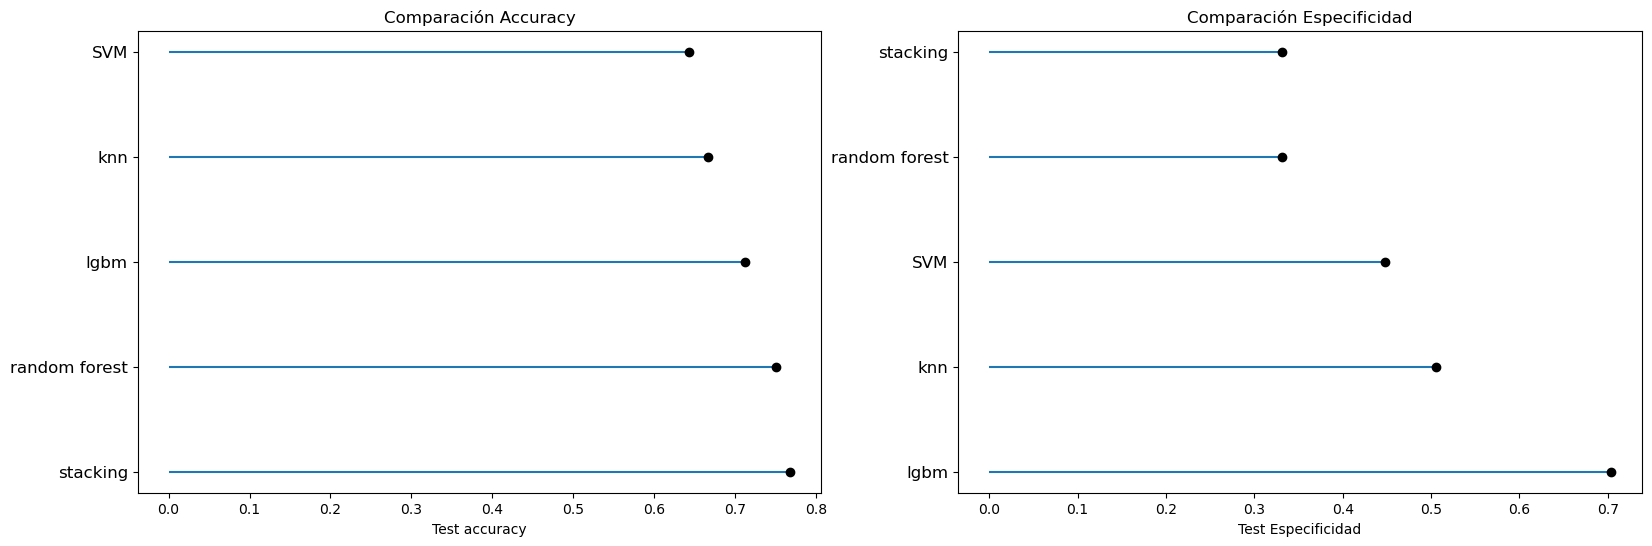

In [55]:
error_modelos = pd.DataFrame({'modelo': ['knn', 'random forest', 'SVM','lgbm','stacking'],
                              'Accuracy': [resul.iloc[1,0], resul.iloc[2,1], resul.iloc[1,2], resul.iloc[2,3], Accuracy_stacking]})
error_modelos = error_modelos.sort_values('Accuracy', ascending=False)

error_modelos1 = pd.DataFrame({'modelo': ['knn', 'random forest', 'SVM','lgbm','stacking'],
                              'Especificidad': [resul2.iloc[0,0], resul2.iloc[1,1], resul2.iloc[0,2], resul2.iloc[1,3], recall_score(y_test,predicciones16)]})
error_modelos1 = error_modelos1.sort_values('Especificidad', ascending=False)

plt.figure(figsize=(30, 6))
plt.subplot(131)
plt.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.Accuracy)
plt.plot(error_modelos.Accuracy, error_modelos.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación Accuracy')
plt.xlabel('Test accuracy')

plt.subplot(132)
plt.hlines(error_modelos1.modelo, xmin=0, xmax=error_modelos1.Especificidad)
plt.plot(error_modelos1.Especificidad, error_modelos1.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación Especificidad')
plt.xlabel('Test Especificidad')
plt.show()



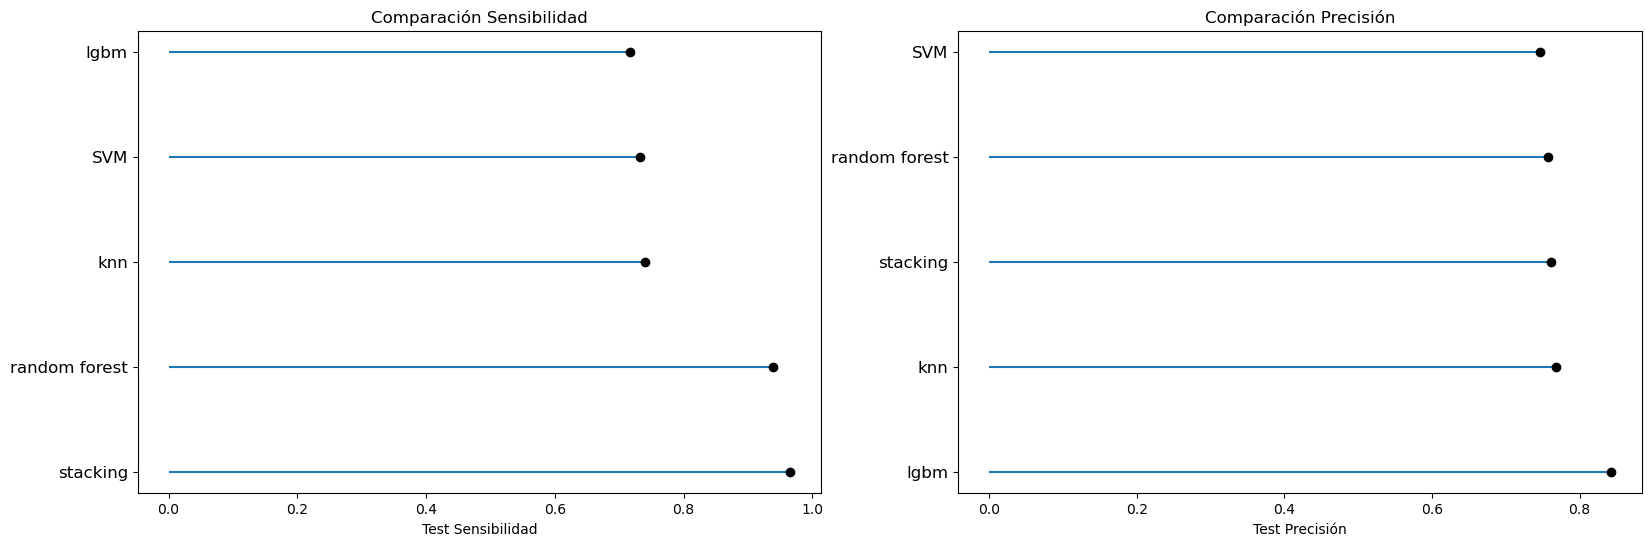

In [57]:
error_modelos2 = pd.DataFrame({'modelo': ['knn', 'random forest', 'SVM','lgbm','stacking'],
                              'Sensibilidad': [resul3.iloc[0,0], resul3.iloc[1,1], resul3.iloc[0,2], resul3.iloc[1,3], recall_score(y_test,predicciones16,average=None)[0]]})
error_modelos2 = error_modelos2.sort_values('Sensibilidad', ascending=False)

error_modelos3 = pd.DataFrame({'modelo': ['knn', 'random forest', 'SVM','lgbm','stacking'],
                              'Precisión': [resul4.iloc[0,0], resul4.iloc[1,1], resul4.iloc[0,2], resul4.iloc[1,3], precision_score(y_test,predicciones16,average=None)[0]]})
error_modelos3 = error_modelos3.sort_values('Precisión', ascending=False)

plt.figure(figsize=(30, 6))
plt.subplot(131)
plt.hlines(error_modelos2.modelo, xmin=0, xmax=error_modelos2.Sensibilidad)
plt.plot(error_modelos2.Sensibilidad, error_modelos2.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación Sensibilidad')
plt.xlabel('Test Sensibilidad')

plt.subplot(132)
plt.hlines(error_modelos3.modelo, xmin=0, xmax=error_modelos3.Precisión)
plt.plot(error_modelos3.Precisión, error_modelos3.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación Precisión')
plt.xlabel('Test Precisión')
plt.show()


Text(0.5, 0, 'Test AUC')

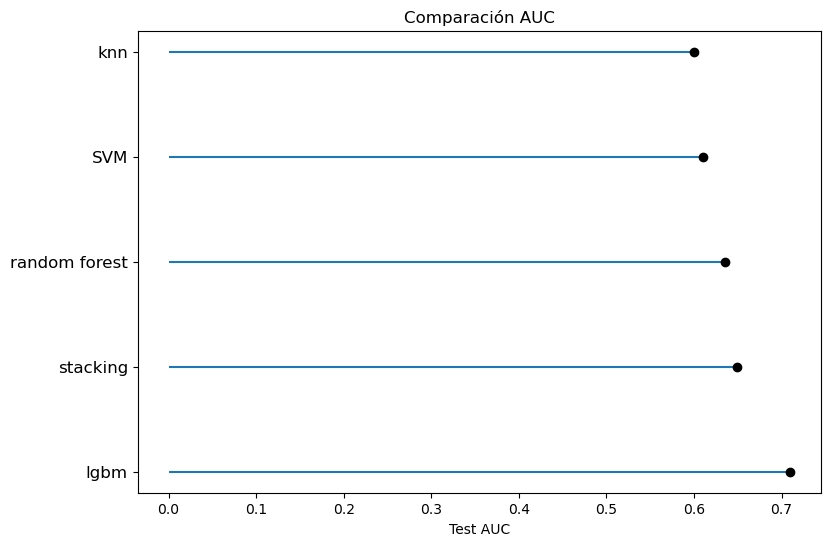

In [58]:
error_modelos = pd.DataFrame({'modelo': ['knn', 'random forest', 'SVM','lgbm','stacking'],
                              'AUC': [AUC_knn, AUC_rf, AUC_SVM, AUC_LGBM, AUC_STAKING]})
error_modelos = error_modelos.sort_values('AUC', ascending=False)

plt.figure(figsize=(30, 6))
plt.subplot(131)
plt.hlines(error_modelos.modelo, xmin=0, xmax=error_modelos.AUC)
plt.plot(error_modelos.AUC, error_modelos.modelo, "o", color='black')
plt.tick_params(axis='y', which='major', labelsize=12)
plt.title('Comparación AUC')
plt.xlabel('Test AUC')

<span style="color:darkblue"> De las 5 métricas a las cuales fueron sometidos los algoritmos el LGBM gana en 3, que son; Especificidad, precisión y AUC. En las otras dos métricas, Precisión y Accuracy el algoritmo ganador es el Stacking.

# <span style="color:darkred"> LGBM

## <span style="color:darkgreen"> Matriz de Confusión

<AxesSubplot:>

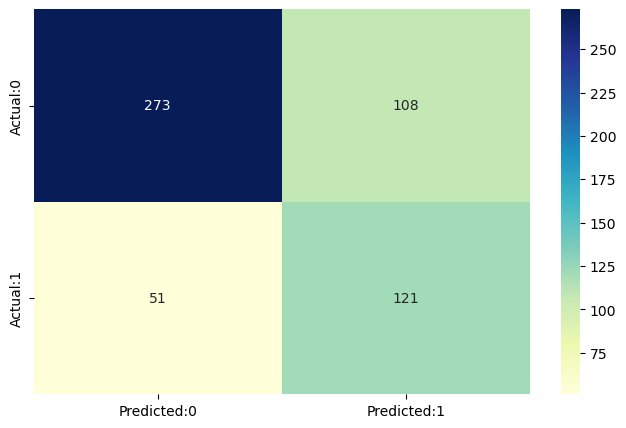

In [59]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,predicciones7)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

## <span style="color:darkgreen"> Importancia de predictores
Importancia por permutación

In [60]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = mejor7,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'recall',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
7,0.272019,0.007119,Ti2
10,0.074453,0.012558,PPPCF
1,0.065207,0.010594,Temp1
12,0.064720,0.012368,Tamin
3,0.056934,0.006813,Temp2
5,0.054988,0.007936,Ti1
11,0.049148,0.006950,pH_Requisito
6,0.035523,0.003300,Temp3
2,0.033090,0.003953,Franja1
13,0.030657,0.010044,Taamax


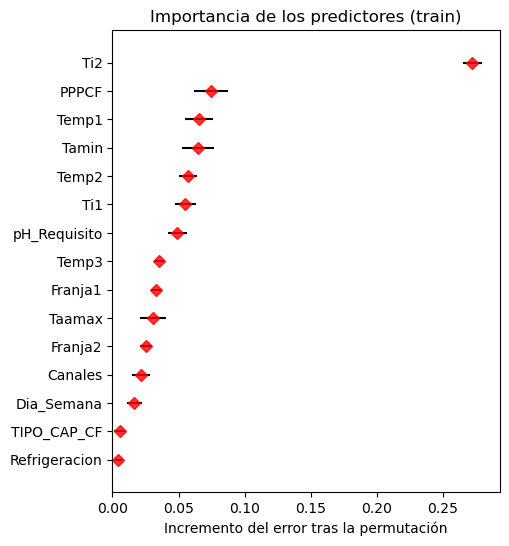

In [61]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');

# <span style="color:darkred"> Stacking


## <span style="color:darkgreen"> Matriz de Confusión 

<AxesSubplot:>

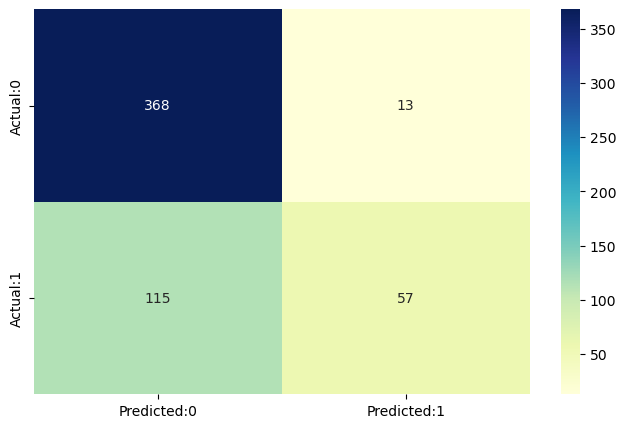

In [62]:
cm=confusion_matrix(y_test,predicciones16)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:0','Predicted:1'],index=['Actual:0','Actual:1'])
plt.figure(figsize = (8,5))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")

## <span style="color:darkgreen"> Importancia de predictores
<span style="color:darkblue"> Importancia por permutación

In [63]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = stacking_cla,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'recall',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
7,0.379562,0.010550,Ti2
12,0.174209,0.013021,Tamin
6,0.168856,0.013468,Temp3
10,0.164964,0.019306,PPPCF
1,0.150365,0.016955,Temp1
3,0.131873,0.009411,Temp2
5,0.126034,0.007755,Ti1
11,0.125547,0.009561,pH_Requisito
4,0.109976,0.014053,Franja2
0,0.101703,0.008344,Dia_Semana


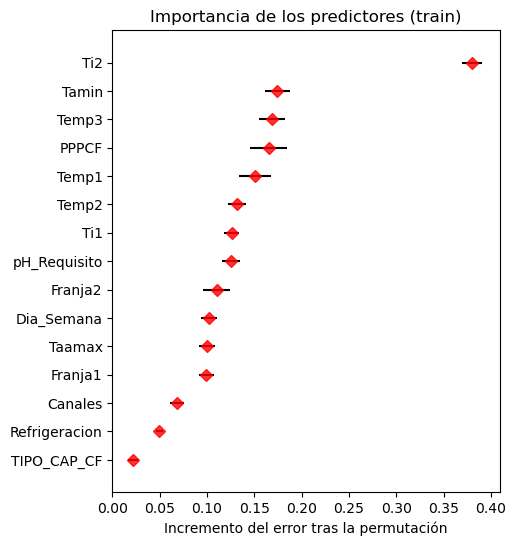

In [64]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 6))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Incremento del error tras la permutación');